## Neural Networks

In this notebook we will code a neural network from scratch and then use it to solve an character recognition task

#### Use following commands in anaconda prompt to replicate this environment:

conda create -n ML python=3.7.5 numpy scipy scikit-learn matplotlib ipykernel 

conda activate ML

conda install -c conda-forge kaggle

python -m ipykernel install --user --name ML --display-name ML

#### Should produce the environment below

In [1]:
print(__import__('sys').version)
!conda list -n ML

3.7.5 (default, Oct 31 2019, 15:18:51) [MSC v.1916 64 bit (AMD64)]
# packages in environment at C:\Anaconda3\envs\ML:
#
# Name                    Version                   Build  Channel
backcall                  0.1.0                    py37_0  
blas                      1.0                         mkl  
ca-certificates           2019.11.28           hecc5488_0    conda-forge
certifi                   2019.11.28               py37_0    conda-forge
cffi                      1.13.2           py37hb32ad35_0    conda-forge
chardet                   3.0.4                 py37_1003    conda-forge
colorama                  0.4.3                      py_0  
cryptography              2.8              py37hb32ad35_1    conda-forge
cycler                    0.10.0                   py37_0  
decorator                 4.4.1                      py_0  
freetype                  2.9.1                ha9979f8_1  
icc_rt                    2019.0.0             h0cc432a_1  
icu                       58

#### Load up a dataset

Kaggle.com has many datasets which are freely available. Simply make an account and sign in. Click on your profile image in the top-right corner. This may be blank if you have not added one. A drop-down box will appear. Select 'My Account', which will load up your account settings. Scroll down untill you see your API options and select 'Create New API Token'. Save this json file to your '.\kaggle' directory. My default on Windows 10 was 'C:\Users\Simon\\.kaggle'

The following code should download and unpack the MNIST dataset from kaggle.com; which is a well known character recognition dataset.

In [1]:
import kaggle, os
kaggle.api.authenticate()
kaggle.api.dataset_download_files('avnishnish/mnist-original', path=os.getcwd(), unzip=True) 

Import numpy and matplotlib libraries. 
The 'inline' argument sets matplotlib figures to display in the notebook rather than in a separate window. 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Load the downloaded dataset into the namespace

In [2]:
from scipy.io import loadmat

data = loadmat(".\mnist-original")
X    = data["data"].T
y    = data["label"][0]
del data

We can see that we have 70k samples with 784 features.

It can be seen that even with small image sizes, the dimensionality of the problem is very large.
This is one of the problems that convolutional layers in Convolutional Neural Networks overcome.

In [3]:
X.shape

(70000, 784)

Each sample is essentially a reshaped 28x28 pixel grey scale image i.e. a 24-bit image that has been flattened into a single 8-bit channel. This means the minimum and maximum values are 0 and 255 respectively. Any negative values or values greater than 255 would be invalid. A quick check looks good:

In [4]:
X.min(), X.max()

(0, 255)

We can also see there is no nan data e.g. 'inf'

In [5]:
sum(isnan(X))

0

In [6]:
X = X.astype(float64)
y = y.astype(uint8)

We can see that there are 10 unique classes

In [7]:
unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Each class is roughly equally representated in the data. We won't be looking at balancing datasets in this notebook.

In [8]:
print(*(f'{i}: {sum(y==i)}' for i in range(10)), sep='\n')

0: 6903
1: 7877
2: 6990
3: 7141
4: 6824
5: 6313
6: 6876
7: 7293
8: 6825
9: 6958


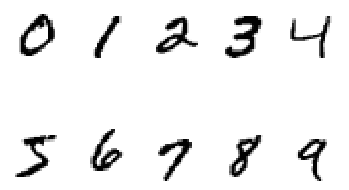

In [9]:
progress = set()

while progress.__len__() < 10:
    for i in range(y.__len__()):
        if y[i] not in progress:
            subplot(2, 5, int(y[i]) + 1)
            imshow(X[i].reshape(28, 28), cmap=cm.gray_r)
            axis('off')
            progress.add(y[i])
show()

We need to convert the numerical class labels into One Hot encoding

In [10]:
n = y.__len__()

y_oh = zeros((n, 10))

y_oh[range(n), y] = 1.

y[0], y_oh[0]

(0, array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

We'll split the data into training and test sets

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, y_train_oh, y_test_oh = train_test_split(X, y, y_oh, test_size=0.2)#, random_state=117)

del X, y, y_oh

y_test.__len__()

14000

Just a sanity check: it can be seen that scikit-learn's train_test_split function ensures each class is roughly equally represented in the training and test sets 

In [12]:
print('Unique labels in training set: ', unique(y_train))
print('Number of each label: ', *(sum(y_train==i) for i in range(10)))
print('Unique labels in test set: ', unique(y_test))
print('Number of each label: ', *(sum(y_test==i) for i in range(10)))

Unique labels in training set:  [0 1 2 3 4 5 6 7 8 9]
Number of each label:  5539 6315 5594 5745 5420 5102 5437 5766 5463 5619
Unique labels in test set:  [0 1 2 3 4 5 6 7 8 9]
Number of each label:  1364 1562 1396 1396 1404 1211 1439 1527 1362 1339


In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The following standardizes the data by: 

## $ z = \frac{x - u}{s} $

where x, u and s the sample value, mean and standard deviation respectively.

## Scratch built MLP

Below is the code for our Multi Layer Perceptron. It is a basic neural network consisting exclusively of fully connected layers.

In [14]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss
from tqdm import tqdm

class MultiLayerPerceptron(BaseEstimator, ClassifierMixin):
    
    '''
    A multilayer perceptron which uses an online gradient descent algorithm with 
    momentum to train the weights by back propagation
    
    Dependencies:
        numpy
        sklearn

    Args:
        n_in                - int, the dimensionality of the input data, number of features
        n_out               - int, the dimensionality of the target vector
        hidden_layers       - list, containing ints of desired weight array dimensions, 
                              n_hidden = len(hidden_layers) and will equal the number of
                              desired hidden layers, when n_hidden == 1 the first two weight 
                              arrays will be of shape [n_in, n_hidden[0]] and [n_hidden[0], n_out], 
                              when len(n_hidden) == 2 the first two weight arrays will be of
                              shape [n_in, n_hidden[0]] and [n_hidden[0], n_hidden[1]]
        learning_rate       - float, effects the step size of gradient decent
        momentum            - float, effects the step size of gradient decent
        max_iter            - int, number of epochs to train model
        random_state        - hashable, to seed random number generator
        one_hot_output      - bool, if True predictions will be one hot encoded, else base 10 numerical
        loss_function       - callable, method, how to calculate error
        cost_function       - callable, method, an average measure of distance/error from targets over
                              multiplesamples/epochs
        internal_activation - callable, method, default='tanh', the activation function used between layers 
                              from inputs and through to the final hidden layer
        output_activation   - callable, method, default='softmax', the activation function used between the 
                              final hidden layer and the output layer
        cost_freq           - int, number of epochs between cost calculation/output
        
    Attributes:
        W                   - list, contains ndarrays of weights of the network,
                              dimenionality is determined by n_in, n_out, n_hidden
        dW                  - list, contains weight deltas for gradient decent
        b                   - list, containing ndarrays of biases
        db                  - list, contains bias deltas for gradient decent
        errors              - list, containing ndarrays of calculated errors of the network
        deltas              - list, containing ndarrays, gradients of the decent
        tanh                - method, numpy.tanh, calculates hyperbolic tangent (Not implemented)
        
    To do:
        implement:
                 mini batch
                 regularization
                 batch normalization
                 
    '''
    
    epsilon = finfo(longdouble).eps
    W       = []
    b       = []
    dW      = []
    db      = []

    def __init__(
                 self,
                 n_in                = 784, 
                 n_out               = 10,
                 hidden_layers       = [100],
                 learning_rate       = 1e-3, 
                 momentum            = 0.9,
                 max_epoch           = 30,
                 random_state        = None,
                 network_id          = None,
                 internal_activation = 'tanh',
                 output_activation   = 'softmax',
                 loss_function       = 'simple_error',
                 cost_function       = 'cross_entropy',
                 one_hot_output      = True,
                 cost_freq           = 10,
                 verbose             = False,
                 ):

        self.n_in                  = n_in
        self.n_out                 = n_out
        self.hidden_layers         = hidden_layers
        self.max_epoch             = max_epoch
        self.learning_rate         = learning_rate
        self.momentum              = momentum
        self.max_epoch             = max_epoch
        self.random_state          = random_state
        self.network_id            = network_id
        
        self.internal_activation   = internal_activation
        self.output_activation     = output_activation
        self.loss_function         = loss_function
        self.cost_function         = cost_function
        
        self.one_hot_output        = one_hot_output
        
        self.internal_activation   = internal_activation
        #self.activation_derivative = internal_activation + '_derivative'
        self.output_activation     = output_activation
        self.loss_function         = loss_function
        self.cost_function         = cost_function
        self.cost_freq             = cost_freq
        
        self.verbose               = verbose
        
        ####################################################################
        #                    Initialize weights and biases                 #
        ####################################################################
        
            
    def _initialize(self):
        
        if self.random_state is not None:
            seed(self.random_state)
            
        self.tanh         = tanh
        self.log_loss     = log_loss
        self.in_act       = getattr(self, self.internal_activation)
        self.in_act_deriv = getattr(self, self.internal_activation + '_derivative')
        self.out_act      = getattr(self, self.output_activation)
        self.loss_func    = getattr(self, self.loss_function)
        self.cost_func    = getattr(self, self.cost_function)
        
        dimensions                 = [self.n_in, *self.hidden_layers, self.n_out]
        self.n_hidden              = self.hidden_layers.__len__()
        n_layers                   = self.n_hidden + 1
        
        self.iter_forward          = list(zip(range(1, self.n_hidden), range(0, self.n_hidden - 1)))
        self.iter_backward         = list(zip(range(self.n_hidden - 1, 0, -1), range(self.n_hidden, 1, -1)))
        self.iter_update           = range(self.n_hidden)
        
        self.activations = [0] * n_layers
        self.errors      = [0] * n_layers
        self.deltas      = [0] * n_layers
        
        for i in range(n_layers):
            self.W.append(uniform(-1., 1., (dimensions[i], dimensions[i + 1])).astype(float64))
            self.dW.append(zeros(self.W[i].shape))
            self.b.append(uniform(-1., 1., (dimensions[i + 1])).astype(float64))
            self.db.append(zeros(self.b[i].shape))
        
    def fit(self, X, y=None, max_epoch=None):
        self._initialize()
        sample_range  = range(X.shape[0])
        if max_epoch is not None:
            self.max_epoch = max_epoch
        self.error_cache = zeros(y.shape) # Will collect error for MSE calculation
        
        for i in tqdm(range(self.max_epoch)):
            self.error_cache *= 0.
            
            for j in range(self.n_hidden + 1):
                self.dW[j] *= 0.
                self.db[j] *= 0.

            for j in sample_range:
                self.x, self.y = X[j], y[j]
                self.feedforward()        
                self.backpropagation()
                self.update()
                
                self.error_cache[j] = self.cost_func(self.y, self.activations[self.n_hidden])
                                      
            if self.verbose and i % 10 == 0: # Print out progress
                
                # Mean squared error is a simple and stable calculation for monitoring
                # learning progress. Cross entropy is perhaps a better indicator for
                # binary classification.
                
                self.error_out = mean(self.error_cache ** 2)
                
                print('Epoch: %s, Loss: %s' % (i, mean(self.error_cache)))
                
        return self

    def predict_proba(self, X):
        '''
        Will return a vector of numbers in the interval [0, 1]. If the output activation function
        is softmax then the numbers will be probabilities i.e. sum to 1.
        '''
        self.x = X
        # Simply feed x forwards through the network
        self.feedforward()
        # Creates a boolean array and converts elements to 0 or 1
        return self.activations[self.n_hidden]
    
    def predict(self, X, one_hot_output=None):
        '''
        Will return predictions. Either base 10 numerical or one hot encoding.
        '''
        if one_hot_output is not None:
            self.one_hot_output = one_hot_output
        activation = self.predict_proba(X)
        output = argmax(activation, axis=1)
        if self.one_hot_output:
            one_hot = zeros(activation.shape)
            one_hot[range(activation.__len__()) , output] = 1.
            output = one_hot
        return output
    
    def feedforward(self):
        
        ###################################################################
        #                           Feedforward                          #
        ###################################################################
        
        # We will collect the network activations

        # input layer
        self.activations[0] = self.in_act(dot(self.x, self.W[0]) + self.b[0])
        # Move the signal from x through the network
        for i, j in self.iter_forward:
            self.activations[i] = self.in_act(dot(self.activations[j], self.W[i]) + self.b[i])
                               
        # output layer
            
        self.activations[self.n_hidden] = self.out_act(
                                                       dot(self.activations[self.n_hidden - 1], \
                                                       self.W[self.n_hidden]) \
                                                       + self.b[self.n_hidden]
                                                       )
                       
    def backpropagation(self):
        
        ###################################################################
        #                           Backpropagation                      #
        ###################################################################
        
        # We will collect the errors 
        # We travel in reverse through the network, starting at the final layer
                       
        self.errors[self.n_hidden] = self.loss_func(self.y, self.activations[self.n_hidden])
        self.deltas[self.n_hidden] = outer(self.activations[self.n_hidden], self.errors[self.n_hidden])
        
        # Now propagate error backwards through the network
        
        for i, j in self.iter_backward:
            self.errors[i] = self.in_act_deriv(self.activations[i]) * dot(self.W[j], self.errors[j])
            self.deltas[i] = outer(self.activations[i], self.errors[i])

        # The error of the first layer
                 
        self.errors[0] = self.in_act_deriv(self.activations[0]) * dot(self.W[1], self.errors[1])
        self.deltas[0] = outer(self.x, self.errors[0])
        
    def update(self):
        
        ######################################################################
        #                       Update weights and biases                    #
        ######################################################################
        
        for i in self.iter_update:
            
            #The update cache is updated
            self.dW[i] = self.dW[i] \
                         * self.momentum \
                         + self.learning_rate \
                         * self.deltas[i]

            self.db[i] = self.db[i] \
                         * self.momentum \
                         + self.learning_rate \
                         * self.errors[i]

            # The parameters are updated from the update cache

            self.W[i] -= self.dW[i]
            self.b[i] -= self.db[i]
            
    ######################################################################
    #                        Activation functions                        #
    ######################################################################
            
    def sigmoid(self, x):
        '''
        Returns the sigmoid of x
        '''
        return 1. / (1. + exp(-x))
    
    def sigmoid_derivative(self, x):
        '''
        Returns derivative of sigmoid(x)
        ''' 
        return x * (1. - x)
    
    def relu(self, x):
        '''
        Returns relu of x
        '''
        return maximum(0., x)

    def relu_derivative(self, x):
        '''
        Returns derivative of relu(x)
        '''
        x[x <= 0.] = 0.
        return x
    
    def softmax(self, x):
        #print(x.shape)
        ex = exp(x)
        return ex / ex.sum()
    
    def softmax_derivative(self, y, y_hat):
        return y_hat - y
    
    def tanh_derivative(self, tanhx):
        '''
        Returns derivative of tanh(x)
        '''
        return  1. - tanhx ** 2.
    
    def simple_error(self, y, y_hat):
        return y_hat - y
    
    def cross_entropy(self, y, y_hat):

        y_hat = clip(y_hat, self.epsilon, 1. - self.epsilon)
        return -(y * log(y_hat) + (1. - y) * log(1. - y_hat))

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

def display_confusion_matrix(
                             targets,
                             predictions,
                             labels=None,
                             normalize=False,
                             title_string='Confusion matrix',
                             cmap=cm.Blues
                             ):
    """
    This function prints and plots a confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    targets     - array-like, numerical target labels
    predictions - 
    """
    if labels is None:
        labels = list(unique(targets))
    
    matrix = confusion_matrix(targets, predictions, labels)
    
    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    figure(figsize=(9, 6))
    style.use('seaborn-white')
    imshow(matrix, interpolation='nearest', cmap=cmap)
    title(title_string)
    colorbar()
    tick_marks = arange(labels.__len__())
    xticks(tick_marks, labels, rotation=45)
    yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in __import__('itertools').product(range(matrix.shape[0]), range(matrix.shape[1])):
        text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    ylabel('True label', fontsize=13)
    xlabel('Predicted label', fontsize=13)
    rc('font', size=13)          # controls default text sizes
    rc('axes', titlesize=13)
    rc('axes', labelsize=13)     # fontsize of the x and y labels
    rc('xtick', labelsize=13)    # fontsize of the tick labels
    rc('ytick', labelsize=13)    # fontsize of the tick labels
    rc('legend', fontsize=13)    # legend fontsize
    tight_layout()
    show()

We will use GridSearchCV from the sklearn library as it allows us to easily parallelize the cross validation process and this will be especially useful because Python isn't the fastest language, even when some of it is calling C/C++ libraries such numpy etc...

We will use cross entropy loss as the performance metric as it is very good when the output from your models are probabilities. Grid search expects a performance metric where higher is better so we will create a custom cross entropy scorer where higher is better i.e. returns -1(cross entropy).  

In [16]:
from sklearn.metrics import log_loss, make_scorer
scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

I left the below cell running over night as it took about 13 hours.

We are basically trying to find the best size and number of hidden layers.

In [17]:
from sklearn.model_selection import GridSearchCV
import multiprocessing

n_free = 1 # number of cpu threads you want to be free (maybe you want to browse the internet)
    
parameters = dict(hidden_layers=[
                                [10], 
                                [25],
                                [50],
                                [75],
                                [100],
                                [150],
                                [200],
                                [10, 10],
                                [25, 25],
                                [50, 50],
                                [75, 75],
                                [100, 100],
                                [200, 200],
                                ])

clf = GridSearchCV(estimator=MultiLayerPerceptron(max_epoch=50, one_hot_output=False),
                   param_grid=parameters, 
                   scoring=scorer,
                   cv=3,
                   n_jobs=multiprocessing.cpu_count() - n_free, 
                   verbose=11,
                   )

clf.fit(X_train, y_train_oh)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed: 17.5min
[Parallel(n_jobs=11)]: Done   2 tasks      | elapsed: 17.5min
[Parallel(n_jobs=11)]: Done   3 tasks      | elapsed: 17.7min
[Parallel(n_jobs=11)]: Done   4 tasks      | elapsed: 33.4min
[Parallel(n_jobs=11)]: Done   5 tasks      | elapsed: 33.7min
[Parallel(n_jobs=11)]: Done   6 tasks      | elapsed: 34.0min
[Parallel(n_jobs=11)]: Done   7 tasks      | elapsed: 74.0min
[Parallel(n_jobs=11)]: Done   8 tasks      | elapsed: 79.9min
[Parallel(n_jobs=11)]: Done   9 tasks      | elapsed: 80.2min
[Parallel(n_jobs=11)]: Done  10 tasks      | elapsed: 117.5min
[Parallel(n_jobs=11)]: Done  11 tasks      | elapsed: 126.6min
[Parallel(n_jobs=11)]: Done  12 tasks      | elapsed: 154.9min
[Parallel(n_jobs=11)]: Done  13 tasks      | elapsed: 169.4min
[Parallel(n_jobs=11)]: Done  14 tasks      | elapsed: 181.7min
[Parallel(n_jobs=11)]: Done  15 tasks      | elaps

GridSearchCV(cv=3, error_score=nan,
             estimator=MultiLayerPerceptron(cost_freq=10,
                                            cost_function='cross_entropy',
                                            hidden_layers=[50],
                                            internal_activation='tanh',
                                            learning_rate=0.001,
                                            loss_function='error_loss',
                                            max_epoch=100, momentum=0.9,
                                            n_in=784, n_out=10, network_id=None,
                                            one_hot_output=False,
                                            output_activation='softmax',
                                            random_state=None, verbose=False),
             iid='deprecated', n_jobs=11,
             param_grid={'hidden_layers': [[10], [25], [50], [75], [100], [150],
                                           [200], [10, 10], [25

The best parameters are used below and it can be seen the results are pretty good considering we have coded this network from scratch.

The most notable/common misclassifications seem to be between 4s and 9s, and between 3s and 5s. 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [27:32<00:00, 16.52s/it]


Confusion matrix, without normalization


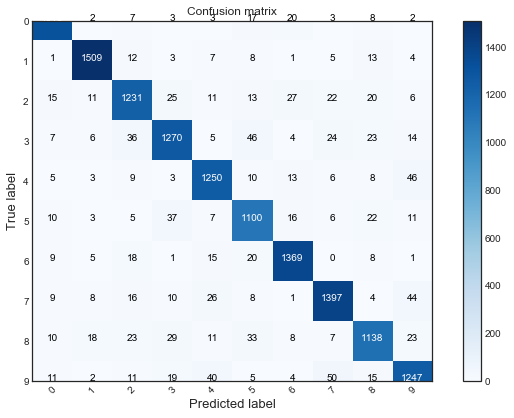

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1378
           1       0.96      0.97      0.96      1563
           2       0.90      0.89      0.90      1381
           3       0.91      0.89      0.90      1435
           4       0.91      0.92      0.92      1353
           5       0.87      0.90      0.89      1217
           6       0.94      0.95      0.94      1446
           7       0.92      0.92      0.92      1523
           8       0.90      0.88      0.89      1300
           9       0.89      0.89      0.89      1404

    accuracy                           0.92     14000
   macro avg       0.91      0.91      0.91     14000
weighted avg       0.92      0.92      0.92     14000



In [18]:
clf.best_estimator_.fit(X_train, y_train_oh)
predictions = clf.best_estimator_.predict(X_test, one_hot_output=False)
#predictions = argmax(predictions, axis=1)
display_confusion_matrix(y_test, predictions)
print(classification_report(y_test, predictions))